In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

Load file and split input from target

Dataset from:
https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

In [3]:
with open("airfoil_self_noise.dat","r") as file:
    csvreader = csv.reader(file, delimiter='\t')
    table = np.asarray([row for row in csvreader], dtype=np.float)
np.set_printoptions(suppress=True) # do not show scientific notation
print(table.shape)
print(table[:3,:])

(1503, 6)
[[ 800.            0.            0.3048       71.3           0.00266337
   126.201     ]
 [1000.            0.            0.3048       71.3           0.00266337
   125.201     ]
 [1250.            0.            0.3048       71.3           0.00266337
   125.951     ]]


normalize data and keep normalizing factors

In [4]:
    xs = table[:,0:-1]
    x_mean, x_std = np.mean(xs), np.std(xs)
    xs = (xs - x_mean)/x_std
    ys = table[:,[-1]]
    y_mean, y_std = np.mean(ys), np.std(ys)
    ys = (ys - y_mean)/y_std

In [5]:
print(xs.shape,ys.shape)
print(ys[:3])

(1503, 5) (1503, 1)
[[0.19793876]
 [0.05293476]
 [0.16168776]]


Split data into train, val, test

In [6]:
def splitDataSetShuffle(inputs, outputs,percent_val_test=10, seed=1):
    assert len(inputs) == len(outputs)
    size = len(inputs)
    np.random.seed(seed)
    shuffle = np.random.permutation(size)
    inps = np.asarray(inputs)[shuffle]
    outs = np.asarray(outputs)[shuffle]
    ts = size * (100-2*percent_val_test) // 100
    vs = size * percent_val_test // 100
    train_set = (inps[:ts], outs[:ts])
    valid_set = (inps[ts:ts + vs], outs[ts:ts + vs])
    test_set = (inps[ts + vs:], outs[ts + vs:])
    return train_set, valid_set, test_set

In [27]:
train_set, valid_set, test_set = splitDataSetShuffle(xs,ys, seed=1)

In [8]:
print(train_set[0].shape, valid_set[0].shape, test_set[0].shape)
print(train_set[1].shape, valid_set[1].shape, test_set[1].shape)

(1202, 5) (150, 5) (151, 5)
(1202, 1) (150, 1) (151, 1)


# 2 layer neural network

In [15]:
class simpleNN(object):
    def __init__(self, input_dim, output_dim, num_hidden_units, seed=2):        
        # initialize weight matrices and bias vectors
        np.random.seed(seed)
        weight_variance =  2.0/(num_hidden_units + input_dim) # Xavier initialization
        self.W1 = np.random.randn(input_dim, num_hidden_units) * weight_variance
        self.b1 = np.zeros(num_hidden_units)
        weight_variance =  2.0/(output_dim + num_hidden_units)
        self.W2 = np.random.randn(num_hidden_units, output_dim) * weight_variance
        self.b2 = np.zeros(output_dim)        
        self.layer1 = None
        
    def evaluate(self, x):                    
        self.layer1 = np.tanh(np.dot(x, self.W1) + self.b1)
        return np.dot(self.layer1, self.W2) + self.b2        
    
    def train_with_square_loss(self, X, y, epsilon=0.001, reg_constant = 0):
        # implement this. 
        # X is the matrix of inputs
        # y is the vector of target outputs
        # loss function: L = Sum_i(f(x_i) - y)_i^2        
        pred = self.evaluate(X)
        delta2 = (pred - y)
        
        delta1 = np.dot(delta2, self.W2.T) * (1-self.layer1**2)
#        print(X.shape, delta2.shape, delta1.shape)
        # derivative of tanh(z) = 1-tanh(x)^2        
        self.W2 += -epsilon * np.dot(self.layer1.T, delta2)
        self.b2 += -epsilon * np.sum(delta2, axis=0)
        self.W1 += -epsilon * np.dot(X.T, delta1)
        self.b1 += -epsilon * np.sum(delta1, axis=0)
        if reg_constant > 0:
            self.W2 += -epsilon * reg_constant * self.W2 
            self.b2 += -epsilon * reg_constant * self.b2
            self.W1 += -epsilon * reg_constant * self.W1
            self.b1 += -epsilon * reg_constant * self.b1
        return np.mean((pred - y)**2)    
                
    def error(self, X, y):
        pred = self.evaluate(X)
        return np.mean((pred - y)**2)
        

Create a network instance with 20 hidden units

In [16]:
net = simpleNN(train_set[0].shape[1], 1, 20)

initial error

In [17]:
net.error(valid_set[0],valid_set[1])

1.103077797180614

## Perform training using gradient decent (using all of the training data at once)

In [18]:
train_errors = []
val_errors = []

In [23]:
for i in range(40000):    
    train_errors.append(net.train_with_square_loss(train_set[0],train_set[1], 0.00005))
    val_errors.append(net.error(*valid_set))

Text(0,0.5,'error')

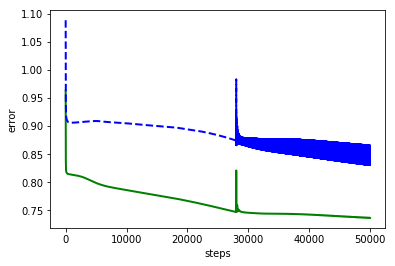

In [24]:
plt.plot(train_errors, color='g', linewidth=2)
plt.plot(val_errors, color='b', linestyle='--', linewidth=2)
#plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("error")

In [26]:
print(net.error(*train_set),net.error(*valid_set),net.error(*test_set))

0.7382239895779193 0.7524655763164048 0.827482814652158


## perform stochastic gradient descent (SGD) (with minibatches)

In [30]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [31]:
net = simpleNN(train_set[0].shape[1], 1, 20)

In [32]:
train_set[0].shape[0]/16

75.125

In [33]:
train_sgd_errors = []
val_sgd_errors = []
steps=0

In [34]:
batch_size = 16
for i in range(50000*75):        
    idxs = np.random.randint(low = 0, high = len(train_set[0]), size=batch_size)
    dat = train_set[0][idxs], train_set[1][idxs]        
    train_sgd_errors.append(net.train_with_square_loss(dat[0],dat[1], 0.0001))    
    steps+=1
    if i%100 ==0: val_sgd_errors.append((steps,net.error(*valid_set)))

Text(0,0.5,'error')

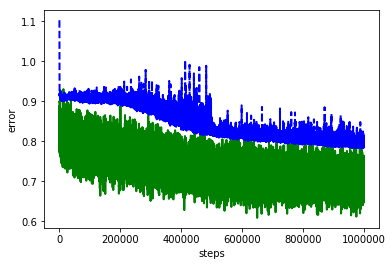

In [21]:
val_sgd_errors_array = np.asarray(val_sgd_errors)
plt.plot(running_mean(train_sgd_errors,100), color='g', linewidth=2)
plt.plot(val_sgd_errors_array[:,0], val_sgd_errors_array[:,1], color='b', linestyle='--', linewidth=2)
#plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("error")

improve this visualization to make the line less wiggly

In [22]:
print(net.error(*train_set),net.error(*valid_set),net.error(*test_set))

0.7087579307326703 0.8193856176832864 0.7525878929565952


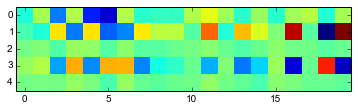

In [204]:
plt.imshow(net.W1, interpolation="nearest")

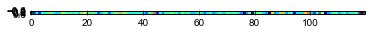

In [166]:
plt.imshow(net.W2.T,interpolation="nearest")

In [36]:
?np.random.randint

## use a larger network

In [11]:
net = simpleNN(train_set[0].shape[1], 1, 150)

In [12]:
train_sgd_errors = []
val_sgd_errors = []
steps=0

In [31]:
batch_size = 16
for i in range(500000):        
    idxs = np.random.randint(low = 0, high = len(train_set[0]), size=batch_size)
    dat = train_set[0][idxs], train_set[1][idxs]        
    train_sgd_errors.append(net.train_with_square_loss(dat[0],dat[1], 0.0002))    
    steps+=1
    if i%100 ==0: val_sgd_errors.append((steps,net.error(*valid_set)))

Text(0,0.5,'error')

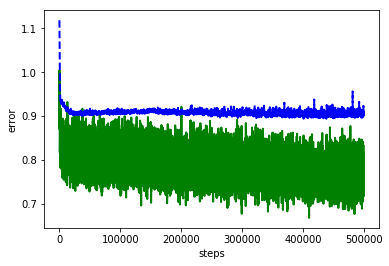

In [32]:
val_sgd_errors_array = np.asarray(val_sgd_errors)
plt.plot(running_mean(train_sgd_errors,100), color='g', linewidth=2)
plt.plot(val_sgd_errors_array[:,0], val_sgd_errors_array[:,1], color='b', linestyle='--', linewidth=2)
#plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("error")

In [209]:
print(net.error(*train_set),net.error(*valid_set),net.error(*test_set))

(0.7890837934151729, 0.905654544393642, 0.8345361324518671)


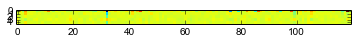

In [210]:
plt.imshow(net.W1, interpolation="nearest")

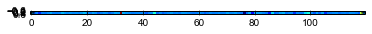

In [211]:
plt.imshow(net.W2.T,interpolation="nearest")

In [31]:
batch_size = 16
for i in range(500000):        
    idxs = np.random.randint(low = 0, high = len(train_set[0]), size=batch_size)
    dat = train_set[0][idxs], train_set[1][idxs]        
    train_sgd_errors.append(net.train_with_square_loss(dat[0],dat[1], 0.0002))    
    steps+=1
    if i%100 ==0: val_sgd_errors.append((steps,net.error(*valid_set)))

Text(0,0.5,'error')

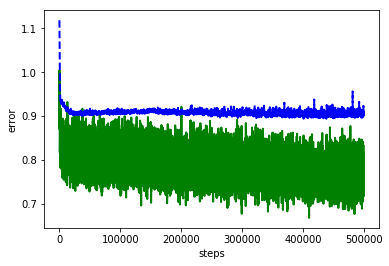

In [32]:
val_sgd_errors_array = np.asarray(val_sgd_errors)
plt.plot(running_mean(train_sgd_errors,100), color='g', linewidth=2)
plt.plot(val_sgd_errors_array[:,0], val_sgd_errors_array[:,1], color='b', linestyle='--', linewidth=2)
#plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("error")

In [209]:
print(net.error(*train_set),net.error(*valid_set),net.error(*test_set))

(0.7890837934151729, 0.905654544393642, 0.8345361324518671)


In [25]:
np.std(net.W1), np.max(net.W1),np.mean(net.W1)

(0.1408644924197778, 2.1013427010476655, 0.002770936846145176)

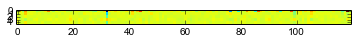

In [210]:
plt.imshow(net.W1, interpolation="nearest")

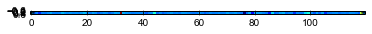

In [211]:
plt.imshow(net.W2.T,interpolation="nearest")

### With regularization

In [12]:
train_sgd_errors = []
val_sgd_errors = []
steps=0

In [48]:
batch_size = 16
for i in range(50000):        
    idxs = np.random.randint(low = 0, high = len(train_set[0]), size=batch_size)
    dat = train_set[0][idxs], train_set[1][idxs]        
    train_sgd_errors.append(net.train_with_square_loss(dat[0],dat[1], 0.00001, 1e-4))    
    steps+=1
    if i%100 ==0: val_sgd_errors.append((steps,net.error(*valid_set)))

Text(0,0.5,'error')

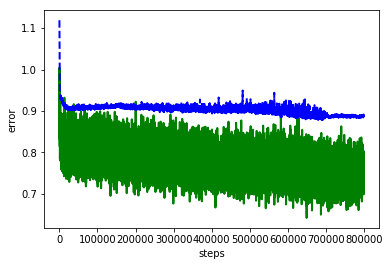

In [49]:
val_sgd_errors_array = np.asarray(val_sgd_errors)
plt.plot(running_mean(train_sgd_errors,100), color='g', linewidth=2)
plt.plot(val_sgd_errors_array[:,0], val_sgd_errors_array[:,1], color='b', linestyle='--', linewidth=2)
#plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("error")

In [50]:
print(net.error(*train_set),net.error(*valid_set),net.error(*test_set))

0.7533851238720483 0.8881363802825027 0.7819042725437365


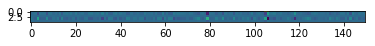

In [51]:
plt.imshow(net.W1, interpolation="nearest")

In [52]:
np.std(net.W1), np.max(net.W1),np.mean(net.W1)

(0.17201399876020998, 2.233119178401535, 0.002970449482575789)

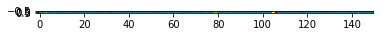

In [22]:
plt.imshow(net.W2.T,interpolation="nearest")